# How to construct knowledge graphs

In this guide we'll go over the basic ways of constructing a knowledge graph based on unstructured text. The constructured graph can then be used as knowledge base in a RAG application.

In [1]:
import os
from dotenv import load_dotenv
load_dotenv()
os.environ["LANGCHAIN_API_KEY"]=os.environ.get('LANGCHAIN_API_KEY')
os.environ["LANGCHAIN_TRACING_V2"]="true"
os.environ["LANGCHAIN_PROJECT"]="Q&A_over_Graph_data"

In [2]:
os.environ["NEO4J_URI"] = os.environ.get('NEO4J_URI')
os.environ["NEO4J_USERNAME"] = os.environ.get('NEO4J_USERNAME')
os.environ["NEO4J_PASSWORD"] = os.environ.get('NEO4J_PASSWORD')

In [11]:
from langchain_community.graphs import Neo4jGraph

graph = Neo4jGraph()



# Architecture
At a high-level, the steps of constructing a knowledge are from text are:

1. Extracting structured information from text: Model is used to extract structured graph information from text.
2. Storing into graph database: Storing the extracted structured graph information into a graph database enables downstream RAG applications

# LLM Graph Transformer

Extracting graph data from text enables the transformation of unstructured information into structured formats, facilitating deeper insights and more efficient navigation through complex relationships and patterns. The LLMGraphTransformer converts text documents into structured graph documents by leveraging a LLM to parse and categorize entities and their relationships. The selection of the LLM model significantly influences the output by determining the accuracy and nuance of the extracted graph data.

In [5]:
import os

from langchain_experimental.graph_transformers import LLMGraphTransformer
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(temperature=0, model_name="gpt-4o-mini")

llm_transformer = LLMGraphTransformer(llm=llm)

Now we can pass in example text and examine the results.



In [6]:
from langchain_core.documents import Document

text = """
Marie Curie, born in 1867, was a Polish and naturalised-French physicist and chemist who conducted pioneering research on radioactivity.
She was the first woman to win a Nobel Prize, the first person to win a Nobel Prize twice, and the only person to win a Nobel Prize in two scientific fields.
Her husband, Pierre Curie, was a co-winner of her first Nobel Prize, making them the first-ever married couple to win the Nobel Prize and launching the Curie family legacy of five Nobel Prizes.
She was, in 1906, the first woman to become a professor at the University of Paris.
"""
documents = [Document(page_content=text)]
graph_documents = llm_transformer.convert_to_graph_documents(documents)
print(f"Nodes:{graph_documents[0].nodes}")
print(f"Relationships:{graph_documents[0].relationships}")

Nodes:[Node(id='Marie Curie', type='Person'), Node(id='Pierre Curie', type='Person'), Node(id='University Of Paris', type='Institution'), Node(id='Nobel Prize', type='Award'), Node(id='Radioactivity', type='Concept')]
Relationships:[Relationship(source=Node(id='Marie Curie', type='Person'), target=Node(id='Nobel Prize', type='Award'), type='WINNER'), Relationship(source=Node(id='Marie Curie', type='Person'), target=Node(id='Radioactivity', type='Concept'), type='RESEARCH_ON'), Relationship(source=Node(id='Marie Curie', type='Person'), target=Node(id='Pierre Curie', type='Person'), type='MARRIED_TO'), Relationship(source=Node(id='Pierre Curie', type='Person'), target=Node(id='Nobel Prize', type='Award'), type='WINNER'), Relationship(source=Node(id='Marie Curie', type='Person'), target=Node(id='University Of Paris', type='Institution'), type='PROFESSOR')]


Examine the following image to better grasp the structure of the generated knowledge graph.

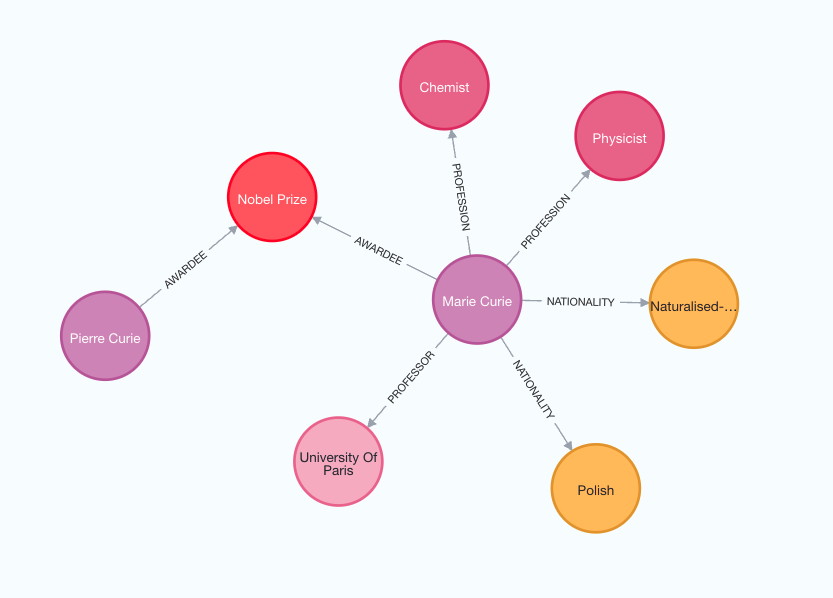


# Adding new nodes and relationships:

Note that the graph construction process is non-deterministic since we are using LLM. Therefore, you might get slightly different results on each execution.

Additionally, you have the flexibility to define specific types of nodes and relationships for extraction according to your requirements.

In [7]:
llm_transformer_filtered = LLMGraphTransformer(
    llm=llm,
    allowed_nodes=["Person", "Country", "Organization"],
    allowed_relationships=["NATIONALITY", "LOCATED_IN", "WORKED_AT", "SPOUSE"],
)
graph_documents_filtered = llm_transformer_filtered.convert_to_graph_documents(
    documents
)
print(f"Nodes:{graph_documents_filtered[0].nodes}")
print(f"Relationships:{graph_documents_filtered[0].relationships}")

Nodes:[Node(id='Marie Curie', type='Person'), Node(id='Pierre Curie', type='Person'), Node(id='University Of Paris', type='Organization'), Node(id='Poland', type='Country'), Node(id='France', type='Country')]
Relationships:[Relationship(source=Node(id='Marie Curie', type='Person'), target=Node(id='Poland', type='Country'), type='NATIONALITY'), Relationship(source=Node(id='Marie Curie', type='Person'), target=Node(id='France', type='Country'), type='NATIONALITY'), Relationship(source=Node(id='Marie Curie', type='Person'), target=Node(id='Pierre Curie', type='Person'), type='SPOUSE'), Relationship(source=Node(id='Marie Curie', type='Person'), target=Node(id='University Of Paris', type='Organization'), type='WORKED_AT')]


For a better understanding of the generated graph, we can again visualize it.

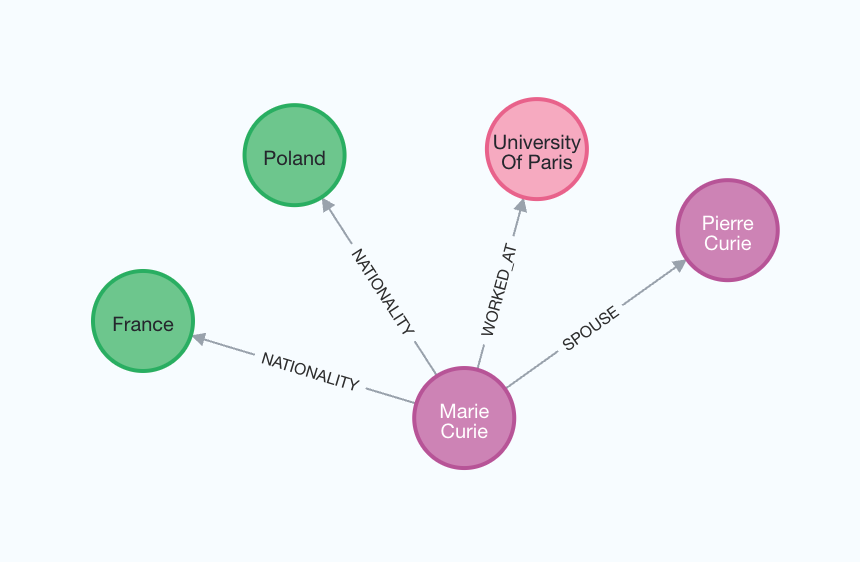

The ```node_properties``` parameter enables the extraction of node properties, allowing the creation of a more detailed graph. When set to ````True```, LLM autonomously identifies and extracts relevant ```node properties```. Conversely, if node_properties is defined as a list of strings, the LLM selectively retrieves only the specified properties from the text.

In [8]:
llm_transformer_props = LLMGraphTransformer(
    llm=llm,
    allowed_nodes=["Person", "Country", "Organization"],
    allowed_relationships=["NATIONALITY", "LOCATED_IN", "WORKED_AT", "SPOUSE"],
    node_properties=["born_year"],
)
graph_documents_props = llm_transformer_props.convert_to_graph_documents(documents)
print(f"Nodes:{graph_documents_props[0].nodes}")
print(f"Relationships:{graph_documents_props[0].relationships}")

Nodes:[Node(id='Marie Curie', type='Person', properties={'born_year': '1867'}), Node(id='Pierre Curie', type='Person'), Node(id='Poland', type='Country'), Node(id='France', type='Country'), Node(id='University Of Paris', type='Organization')]
Relationships:[Relationship(source=Node(id='Marie Curie', type='Person'), target=Node(id='Poland', type='Country'), type='NATIONALITY'), Relationship(source=Node(id='Marie Curie', type='Person'), target=Node(id='France', type='Country'), type='NATIONALITY'), Relationship(source=Node(id='Marie Curie', type='Person'), target=Node(id='Pierre Curie', type='Person'), type='SPOUSE'), Relationship(source=Node(id='Marie Curie', type='Person'), target=Node(id='University Of Paris', type='Organization'), type='WORKED_AT')]


In [12]:
graph.add_graph_documents(graph_documents_props)